In [ ]:
!pip install transformers
!pip install scipy
!pip install torch torchvision 
!pip install matplotlib
# Runtime might need restarting after this installation.
!pip install tdqm
!pip install twitscrape
# twitscrape is a package I created as an aside to this project to further bolster my learning (https://github.com/christywastaken/twitscrape, https://pypi.org/project/twitscrape). 
# I'm sure there are more effective ways of collecting the tweet data used in this project. If you are looking to repeat this data analysis I would reccomend looking for another package such as snscrape.

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [12]:
import pandas as pd
import re

def clean_tweets(tweet_df: pd.DataFrame) -> pd.DataFrame:
    cleaned_tweet_df = tweet_df.copy()
    for index, row in cleaned_tweet_df.iterrows():
        tweet_text = row['tweet_text']
        clean_tweet_text = re.sub("@[A-Za-z0-9_]+","", tweet_text)
        #TODO: Should I replace @mentions with a name like 'Daniel' to help the sentiment analysis? Or should I include @mentions as original? test this.
        clean_tweet_text = re.sub("#[A-Za-z0-9_]+","", clean_tweet_text)
        clean_tweet_text = clean_tweet_text.lower()
        print(f'\ntweet: {tweet_text}\nclean: {clean_tweet_text}\n')
        
        cleaned_tweet_df.at[index, 'cleaned_tweet_text'] = clean_tweet_text
    
    return cleaned_tweet_df


In [4]:
import sqlite3

class SQLContextManager():
    """ Context manager for SQL db """
    def __init__(self, host):
        self.connection = None
        self.host = host

    def __enter__(self):
        self.connection = sqlite3.connect(self.host)
        return self.connection
        
    def __exit__(self, exc_type, exc_val, exc_tab):
        self.connection.commit()
        self.connection.close()
        
        

In [60]:
import pandas as pd
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
from transformers import logging
from scipy.special import softmax
import numpy as np
from tqdm.auto import tqdm

#TODO: Check licensing and citing for https://github.com/cardiffnlp/timelms 
#TODO: consider saving model to local.
#TODO: leave as class or not?

class SentimentAnalysis():
    
    def __init__(self):
        logging.set_verbosity_error()
        self.MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
        self.tokenizer = AutoTokenizer.from_pretrained(self.MODEL)
        self.config = AutoConfig.from_pretrained(self.MODEL)
        self.model = AutoModelForSequenceClassification.from_pretrained(self.MODEL)
        

    def preprocess(self, text):
        new_text = []
        for t in text.split(" "):
            t = '@user' if t.startswith('@') and len(t) > 1 else t
            t = 'http' if t.startswith('http') else t
            new_text.append(t)
        return " ".join(new_text)


    def analyse_sentiment(self, tweet_df: pd.DataFrame) -> pd.DataFrame:
        """ Analyses the sentiment of tweets and returns a dataframe with new columns 'negative', 'neutral' and 'positive' """
        print('Running sentiment analysis. This could take a while.')
        tweet_df_copy = tweet_df.copy()
        # model.save_pretrained(MODEL) #TODO: consider saving to local
        for index, row in tqdm(tweet_df_copy.iterrows(), total=tweet_df_copy.shape[0]):
            try:
                tweet_text = row['tweet_text']
                tweet_text = self.preprocess(tweet_text)
                encoded_input = self.tokenizer(tweet_text, return_tensors='pt')
                output = self.model(**encoded_input)
                scores = output[0][0].detach().numpy()
                scores = softmax(scores)
                scores = np.round(scores.astype(float), 4)
                sentiment_dict = {self.config.id2label[i]: score for i, score in enumerate(scores)}
                for column, value in sentiment_dict.items():
                    tweet_df_copy.at[index, column] = value
                # print(f'tweet: {tweet_text} | senti: {sentiment_dict}')
            except Exception as err:
                print(f'Error at index:{index} | Error: {err}')
        return tweet_df_copy

    


/Users/christianharrison/Documents/Code/learn/purple-beard/capstone/sentiment_analysis/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [28]:
import pandas as pd
from datetime import datetime

def add_epoch_time_and_sort(tweet_df: pd.DataFrame) -> pd.DataFrame:
    """ Adds epoch_seconds column to df and sorts by epoch_seconds ascending """
    
    tweet_df_copy = tweet_df.copy()
    date_format = "%a %b %d %H:%M:%S %z %Y"

    for index, row in tweet_df_copy.iterrows():
        try:
            created_at = row['created_at']
            epoch_seconds = datetime.strptime(created_at, date_format).timestamp()
            tweet_df_copy.at[index, 'epoch_seconds'] = epoch_seconds
        except Exception as err:
            print(f'Error: {err}')
    tweet_df_copy.sort_values(by='epoch_seconds', inplace=True, ignore_index=True)
    tweet_df_copy.reset_index(inplace=True, drop=True)
    return tweet_df_copy


In [7]:
# Testing whether data is missing
import pandas as pd

def check_gaps_in_data(tweet_df: pd.DataFrame) -> pd.DataFrame:
    """ Adds time_diff_mins coloumn to df which can be used for identifying holes in data. This column is the time betweent the current and next tweet """
    tweet_df_copy = tweet_df.copy()
    
    largest_time_diff = 0.0
    index_largest_diff = 0
    for index, row in tweet_df_copy.iterrows():
        try:
            epoch_seconds1 = tweet_df_copy.iloc[index]['epoch_seconds']
            epoch_seconds2 = tweet_df_copy.iloc[index+1]['epoch_seconds']
            
            time_diff = epoch_seconds2 - epoch_seconds1
            time_diff_mins = round((time_diff / 60), 2)
            if time_diff_mins > largest_time_diff:
                largest_time_diff = time_diff_mins
                index_largest_diff = index
            tweet_df_copy.at[index, 'time_diff_mins'] = time_diff_mins
            

        except Exception as err:
            print(f'Error: {err}')
    print(f'-- The largest gap in data is: {largest_time_diff} mins at index: {index_largest_diff} --')
    return tweet_df_copy






In [ ]:

from twitscrape.twitter_scraper import TwitterGeolocationScraper 
# twitscrape is a package I built and distributed as an aside, learning experiment to this project. I plan to work on it further so the import method might change from the above.
# https://github.com/christywastaken/twitscrape 
# https://pypi.org/project/twitscrape/ 

newcastle_latitude = 54.975029
newcastle_longitude = -1.612477
search_radius_km = 15.0
twitter_scraper = TwitterGeolocationScraper(start_date='2022-01-01', end_date='2023-01-01', latitude=newcastle_latitude, longitude=newcastle_longitude, radius=search_radius_km, filter_links=True, filter_replies=True, is_headless=True)
tweet_df = twitter_scraper.run()
# Creates dataframe of all the tweets in Newcastle-Upon-Tyne for a 15km radius for all of 2022. No replies or tweets containing media included.

#Store DF to SQL DB
with SQLContextManager('twitter_sentiment_analysis.db') as connection:
    tweet_df.to_sql('all_2022', connection, if_exists='replace', index=False)




In [3]:
# Add epoch_seconds to SQL db.
with SQLContextManager('twitter_sentiment_analysis.db') as connection:
    query = "SELECT * FROM all_2022"
    tweet_df = pd.read_sql(query, connection)
    epoc_tweet_df = add_epoch_time_and_sort(tweet_df=tweet_df)
    epoc_tweet_df.to_sql('all_2022', con=connection, if_exists='replace', index=False)



NameError: name 'SQLContextManager' is not defined

In [9]:
# check for gaps in data and sort by largest gaps.
with SQLContextManager('twitter_sentiment_analysis.db') as connection:
    query = "SELECT * FROM all_2022"
    tweet_df = pd.read_sql(query, connection)

tweet_df_time_gaps = check_gaps_in_data(tweet_df)
tweet_df_time_gaps.sort_values(by='time_diff_mins', inplace=True, ascending=False)


Error: single positional indexer is out-of-bounds
-- The largest gap in data is: 556.58 mins at index: 30882 --


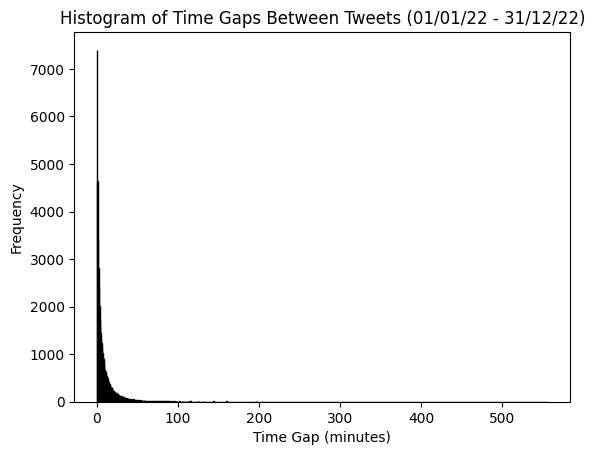

In [10]:
# visiualizing gaps in the data 
import matplotlib.pyplot as plt

plt.hist(tweet_df_time_gaps['time_diff_mins'], bins='auto', edgecolor='black')
plt.title('Histogram of Time Gaps Between Tweets (01/01/22 - 31/12/22)')
plt.xlabel('Time Gap (minutes)')
plt.ylabel('Frequency')
plt.show()

In [44]:
# Getting some numbers on the gaps in the data
data_size = len(tweet_df_time_gaps)
for time in [60,120,360,420,480]:
    num_gaps = sum(tweet_df_time_gaps['time_diff_mins']>time)
    print(f'Percentage of tweets with gap >{str(time)} mins: {round(((num_gaps/data_size)*100),4)}%')


Percentage of tweets with gap >60 mins: 2.2118%
Percentage of tweets with gap >120 mins: 0.7333%
Percentage of tweets with gap >360 mins: 0.0198%
Percentage of tweets with gap >420 mins: 0.004%
Percentage of tweets with gap >480 mins: 0.002%


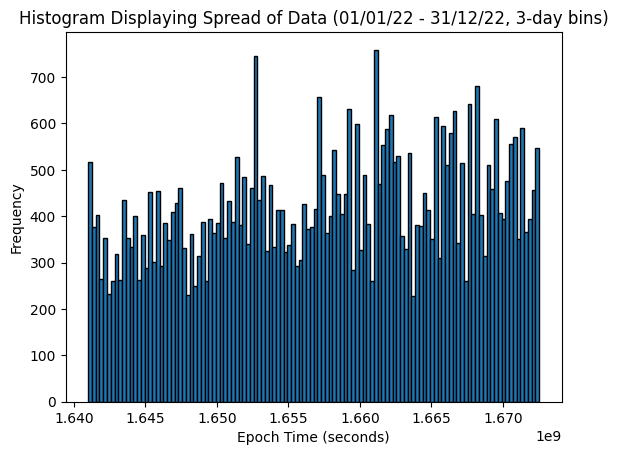

In [93]:
# Visualising spread of data using epoch time in seconds.
plt.hist(tweet_df_time_gaps['epoch_seconds'], bins=120,edgecolor='black')
plt.title('Histogram Displaying Distribution of Data (01/01/22 - 31/12/22, 3-day bins)')
plt.xlabel('Epoch Time (seconds)')
plt.ylabel('Frequency')
plt.show()

In [101]:
# analyse the sentiment of the data. 
with SQLContextManager('twitter_sentiment_analysis.db') as connection:
    query = "SELECT * FROM all_2022"
    tweet_df = pd.read_sql(query, connection)
    sentiment_tweet_df = SentimentAnalysis().analyse_sentiment(tweet_df=tweet_df)
    sentiment_tweet_df.to_sql('all_2022_sentiment', connection, if_exists='replace', index=False)

Running sentiment analysis. This could take a while.


  1%|▏         | 653/50593 [01:24<1:28:41,  9.38it/s]

Error at index:651 | Error: The expanded size of the tensor (535) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 535].  Tensor sizes: [1, 514]


 13%|█▎        | 6707/50593 [15:28<1:55:02,  6.36it/s]

Error at index:6705 | Error: The expanded size of the tensor (842) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 842].  Tensor sizes: [1, 514]


 48%|████▊     | 24153/50593 [55:54<45:33,  9.67it/s]  

Error at index:24152 | Error: The expanded size of the tensor (1091) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1091].  Tensor sizes: [1, 514]


100%|██████████| 50593/50593 [1:53:04<00:00,  7.46it/s]  


In [111]:
# Looking into error-causing tweets.

print(sentiment_tweet_df.iloc[651]['tweet_text'])
print(sentiment_tweet_df.iloc[6705]['tweet_text'])
print(sentiment_tweet_df.iloc[24152]['tweet_text'])



จริงๆ งานกลุ่มมันดีนะ เห็นคนบ่นเยอะ ซึ่งก็มาถูกทางและ แต่ต้องคิดbeyondหน่อย ทำงานกลุ่มคือฝึกทำงานกับคนหลากหลาย มันต้องมีปัญหาอยู่แล้ว ก็ต้องหาวิธีแก้ปัญหาให้ทำงานร่วมกันได้ (ทั้งครูและนรเอง) ไม่ใช่ให้ยกเลิกงานกลุ่มละขอทำเดี่ยวแทนงี้ ชีวิตการทำงานจริงมันก็หนีแบบนี้ไม่ได้เสมอไปปะ
🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦
England's Lionesses.. Outstanding.
🏴󠁧󠁢󠁥󠁮󠁧󠁿 👏🏻🏴󠁧󠁢󠁥󠁮󠁧󠁿👏🏻🏴󠁧󠁢󠁥󠁮󠁧󠁿👏🏻🏴󠁧󠁢󠁥󠁮󠁧󠁿👏🏻🏴󠁧󠁢󠁥󠁮󠁧󠁿👏🏻🏴󠁧󠁢󠁥󠁮󠁧󠁿👏🏻🏴󠁧󠁢󠁥󠁮󠁧󠁿🏴󠁧󠁢󠁥󠁮󠁧󠁿👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻🏴󠁧󠁢󠁥󠁮󠁧󠁿🏴󠁧󠁢󠁥󠁮󠁧󠁿🏴󠁧󠁢󠁥󠁮󠁧󠁿🏴󠁧󠁢󠁥󠁮󠁧󠁿👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻🏴󠁧󠁢󠁥󠁮󠁧󠁿🏴󠁧󠁢󠁥󠁮󠁧󠁿🏴󠁧󠁢󠁥󠁮󠁧󠁿🏴󠁧󠁢󠁥󠁮󠁧󠁿👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻🏴󠁧󠁢󠁥󠁮󠁧󠁿🏴󠁧󠁢󠁥󠁮󠁧󠁿🏴󠁧󠁢󠁥󠁮󠁧󠁿🏴󠁧󠁢󠁥󠁮󠁧󠁿👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻🏴󠁧󠁢󠁥󠁮󠁧󠁿🏴󠁧󠁢󠁥󠁮󠁧󠁿🏴󠁧󠁢󠁥󠁮󠁧󠁿🏴󠁧󠁢󠁥󠁮󠁧󠁿👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻🏴󠁧󠁢󠁥󠁮󠁧󠁿🏴󠁧󠁢󠁥󠁮󠁧󠁿🏴󠁧󠁢󠁥󠁮󠁧󠁿🏴󠁧󠁢󠁥󠁮󠁧󠁿👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻🏴󠁧󠁢󠁥󠁮󠁧󠁿🏴󠁧󠁢󠁥󠁮󠁧󠁿


In [115]:
# Find dataframe rows that don't have sentiment values.
missing_values = sentiment_tweet_df[(sentiment_tweet_df['negative'].isna()) | (sentiment_tweet_df['neutral'].isna()) | (sentiment_tweet_df['positive'].isna())]

# Drop rows with missing sentiment data.
sentiment_tweet_df.dropna(subset=['negative', 'neutral', 'positive'], inplace=True)

#Save to SQL
with SQLContextManager('twitter_sentiment_analysis.db') as connection:
    sentiment_tweet_df.to_sql('all_2022_sentiment', connection, if_exists='replace', index=False)

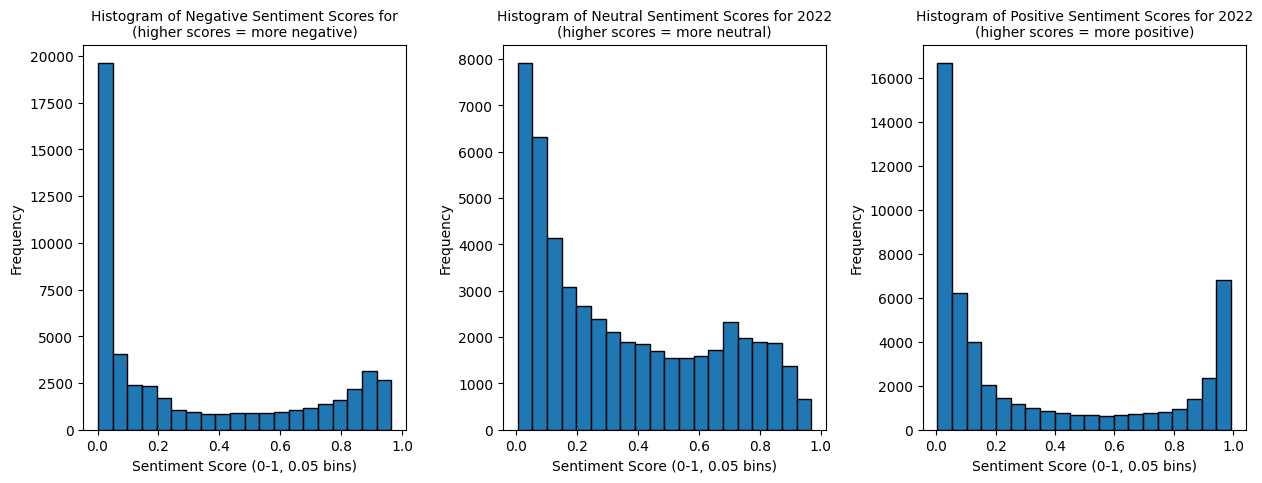

In [121]:
# Frequency distribution for positive, negative and neutral sentiments of tweets
# Note: this could be systematically skewed by the model used.

fig, axes = plt.subplots(1,3, figsize=(15,5))

axes[0].hist(sentiment_tweet_df['negative'], bins=20, edgecolor='black')
axes[0].set_title('Histogram of Negative Sentiment Scores for\n(higher scores = more negative)', fontsize=10)
axes[0].set_xlabel('Sentiment Score (0-1, 0.05 bins)')
axes[0].set_ylabel('Frequency')

axes[1].hist(sentiment_tweet_df['neutral'], bins=20, edgecolor='black')
axes[1].set_title('Histogram of Neutral Sentiment Scores for 2022\n(higher scores = more neutral)', fontsize=10)
axes[1].set_xlabel('Sentiment Score (0-1, 0.05 bins)')
axes[1].set_ylabel('Frequency')

axes[2].hist(sentiment_tweet_df['positive'], bins=20, edgecolor='black')
axes[2].set_title('Histogram of Positive Sentiment Scores for 2022\n(higher scores = more positive)', fontsize=10)
axes[2].set_xlabel('Sentiment Score (0-1, 0.05 bins)')
axes[2].set_ylabel('Frequency')

plt.subplots_adjust(wspace=0.3)

plt.show()

In [ ]:
# Converting created_at to datetime and store SQL
with SQLContextManager('twitter_sentiment_analysis.db') as connection:
    sentiment_tweet_df['created_at'] = pd.to_datetime(sentiment_tweet_df['created_at'], format='%a %b %d %H:%M:%S %z %Y')
    sentiment_tweet_df.to_sql('all_2022_sentiment_test', connection, if_exists='replace', index=False)



In [32]:
# Removing timezone info
with SQLContextManager('twitter_sentiment_analysis.db') as connection:
    query = "SELECT * FROM all_2022_sentiment"
    sentiment_df = pd.read_sql(query, connection)
    sentiment_df['created_at'] = pd.to_datetime(sentiment_df['created_at']).dt.tz_localize(None)
    sentiment_df.to_sql('all_2022_sentiment', connection,if_exists='replace', index=False)

In [47]:
# Exploring how sentiment changes throughout the day

# Get df with only created_at and sentiment.
with SQLContextManager('twitter_sentiment_analysis.db') as connection:
    query = "SELECT created_at, negative, neutral, positive FROM all_2022_sentiment"
    sentiment_df = pd.read_sql(query, connection)



/var/folders/pk/96tttlks01jd7q3pb6qfr40m0000gn/T/ipykernel_20891/1641124546.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_1h_mean = sentiment_df.groupby('hour').mean()
/var/folders/pk/96tttlks01jd7q3pb6qfr40m0000gn/T/ipykernel_20891/1641124546.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_1h_median = sentiment_df.groupby('hour').median()


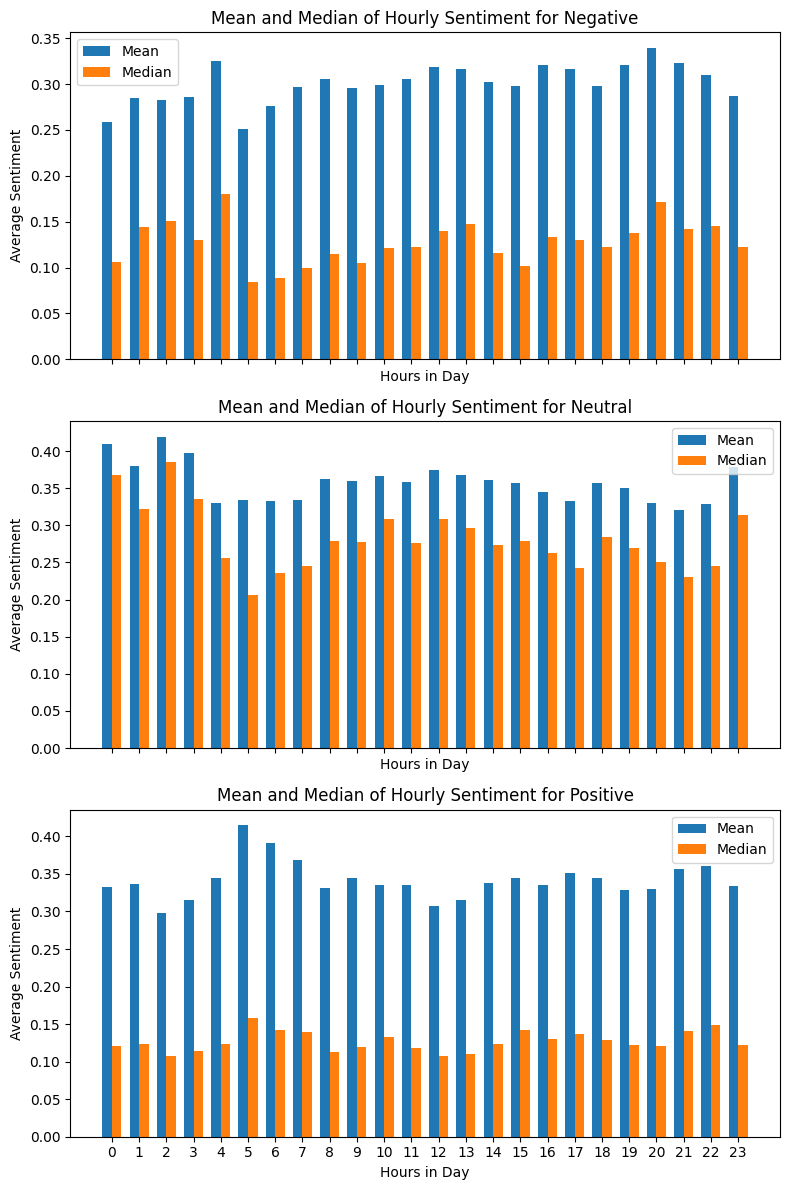

In [67]:
# Exploring how sentiment changes throughout the day
# Grouping at 1hr intervals.
sentiment_df['created_at'] = pd.to_datetime(sentiment_df['created_at'])
sentiment_df['hour'] = sentiment_df['created_at'].dt.hour
grouped_1h_mean = sentiment_df.groupby('hour').mean()
grouped_1h_median = sentiment_df.groupby('hour').median()


# Displaying mean and median
hours = grouped_1h_mean.index
x = np.arange(len(hours))
width = 0.35

fig, axes = plt.subplots(3,1, figsize=(8,12), sharex=True)
columns = ['negative', 'neutral', 'positive']

for i, col in enumerate(columns):
    mean_values = grouped_1h_mean[col]
    median_values = grouped_1h_median[col]

    rects1 = axes[i].bar(x - width/2, mean_values, width, label='Mean')
    rects2 = axes[i].bar(x + width/2, median_values, width, label='Median')

    axes[i].set_title(f'Mean and Median of Hourly Sentiment for {col.capitalize()}')
    axes[i].set_ylabel('Average Sentiment')
    axes[i].set_xlabel('Hours in Day')
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(hours)
    axes[i].legend()

# fig.text(0.5, 0.04, 'Hour', ha='center', va='center')
plt.tight_layout()
plt.show()
   


,negative,neutral,positive
created_at,,,
2022-01-01 00:00:01,0.0030,0.0177,0.9793
2022-01-01 00:01:13,0.0101,0.0579,0.9320
2022-01-01 00:01:16,0.0062,0.0188,0.9750
2022-01-01 00:02:57,0.1429,0.7297,0.1274
2022-01-01 00:02:58,0.0086,0.0209,0.9705
...,...,...,...
2022-12-31 23:40:44,0.0043,0.0208,0.9749
2022-12-31 23:44:37,0.0042,0.0115,0.9842
2022-12-31 23:51:24,0.4249,0.4891,0.0859
